<a href="https://colab.research.google.com/github/nishitsugandh/cifar10-image-classifier/blob/main/cifar10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the dataset

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms

# Normalize images to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Defining the CNN

In [2]:


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # input: 3 channels (RGB), output: 16 filters
        self.pool = nn.MaxPool2d(2, 2)               # reduces image size by 2x
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)         # fully connected layer
        self.fc2 = nn.Linear(128, 10)                 # 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))         # Conv1 + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))         # Conv2 + ReLU + MaxPool
        x = x.view(-1, 32 * 8 * 8)                    # Flatten
        x = F.relu(self.fc1(x))                      # FC1 + ReLU
        x = self.fc2(x)                              # Output layer
        return x

net = Net()



Training the Network

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

losses = []
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/5, Loss: 1.3832
Epoch 2/5, Loss: 1.0173
Epoch 3/5, Loss: 0.8709
Epoch 4/5, Loss: 0.7693
Epoch 5/5, Loss: 0.6812


Sample Predictions

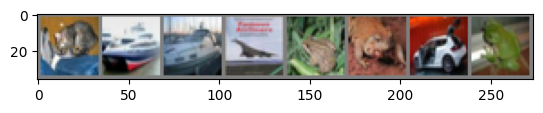

Predicted:  dog | ship | plane | plane | frog | frog | car | deer
Actual:     cat | ship | ship | plane | frog | frog | car | frog


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict using trained model
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show images with predicted & actual labels
imshow(torchvision.utils.make_grid(images[:8]))
print("Predicted: ", ' | '.join(f'{classes[predicted[j]]}' for j in range(8)))
print("Actual:    ", ' | '.join(f'{classes[labels[j]]}' for j in range(8)))


Losses

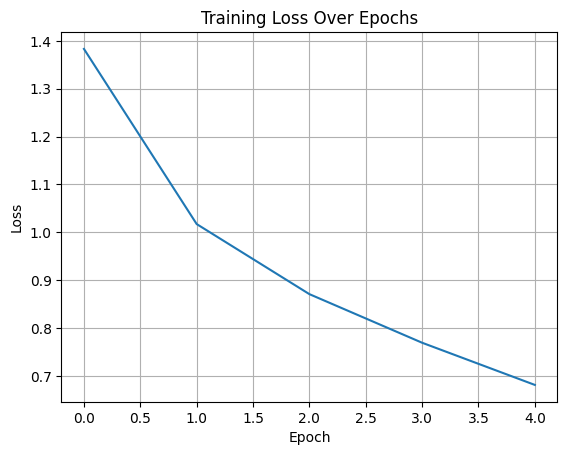

In [7]:
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Confusion Matrix

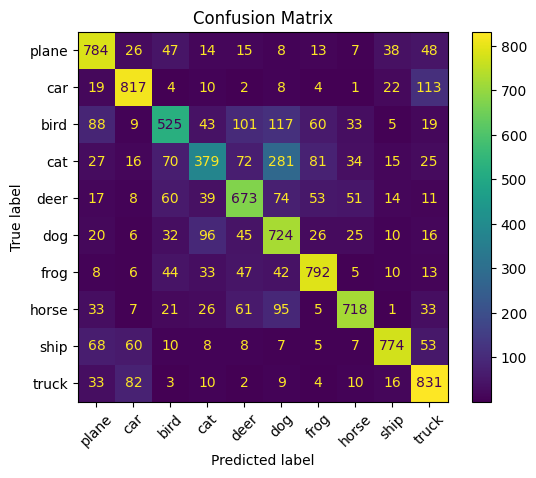

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gather all predictions
all_preds = torch.tensor([])
all_labels = torch.tensor([])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Accuracy

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 70.17%
